In [156]:
import pandas as pd
import numpy as np
import requests

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

SMALL_SIZE = 22 
MEDIUM_SIZE = 28 
BIGGER_SIZE = 36 

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

%matplotlib inline

In [146]:
fc_col = (132, 167, 70)
pl2_col = (116, 54, 135)
wl2_col = (228, 178, 69)
hl2_col = (202, 91, 45)
hl1_col = (45, 112, 183)
raw_colors = [fc_col, pl2_col, wl2_col, hl2_col, hl1_col]

colors = []
for t in reversed(raw_colors):
    colors.append(tuple(map(lambda x: x/255, t)))

In [160]:
in_file = '../output/20200804_10C_min_delay.csv'

In [161]:
df = pd.read_csv(in_file)

In [162]:
df.shape

(42972231, 17)

In [163]:
df.head()

,loc_class,temp_c,fleet_size,mean_dvmt,pev_dist,pref_dist,home_access_dist,home_power_dist,work_power_dist,class_dist,day_of_week,pev_type,dest_type,dest_chg_level,class_type,time_of_day,kw
0,urban,10,1000,25,BEV,Home100,HA100,MostL1,MostL2,Sedan,weekday,PHEV20,Home,L1,Sedan,0.25,13.871523
1,urban,10,1000,25,BEV,Home100,HA100,MostL1,MostL2,Sedan,weekday,PHEV20,Home,L1,Sedan,0.50,11.410689
2,urban,10,1000,25,BEV,Home100,HA100,MostL1,MostL2,Sedan,weekday,PHEV20,Home,L1,Sedan,0.75,8.400086
3,urban,10,1000,25,BEV,Home100,HA100,MostL1,MostL2,Sedan,weekday,PHEV20,Home,L1,Sedan,1.00,8.400086
4,urban,10,1000,25,BEV,Home100,HA100,MostL1,MostL2,Sedan,weekday,PHEV20,Home,L1,Sedan,1.25,8.400086


In [172]:
temp_c = 10 
fleet_size = 30000
mean_dvmt = 35
pev_dist = 'BEV'
pref_dist = 'Home100'
home_access_dist = 'HA75'
home_power_dist = 'Equal'
work_power_dist = 'MostL2'
class_dist = 'Equal'
day_of_week = 'weekday'

In [165]:
sub_df = df[
    (df.fleet_size == fleet_size) &
    (df.mean_dvmt == mean_dvmt) &
    (df.class_dist == class_dist) &
    (df.pev_dist == pev_dist) &
    (df.work_power_dist == work_power_dist) &
    (df.home_power_dist == home_power_dist) &
    (df.home_access_dist == home_access_dist) &
    (df.pref_dist == pref_dist) &
    (df.day_of_week == day_of_week)
].copy()

In [166]:
sub_df['type'] = sub_df.dest_type + sub_df.dest_chg_level

In [167]:
plot_df = pd.DataFrame(sub_df.groupby(['type', 'time_of_day']).kw.sum())

In [168]:
plot_df = plot_df.reset_index().pivot(index='time_of_day', columns='type', values='kw').fillna(0)/1000

In [169]:
cols = ['HomeL1', 'HomeL2', 'WorkL1', 'WorkL2', 'PublicL2', 'PublicL3', ]

Text(0, 0.5, 'Weekday PEV chg load, MW')

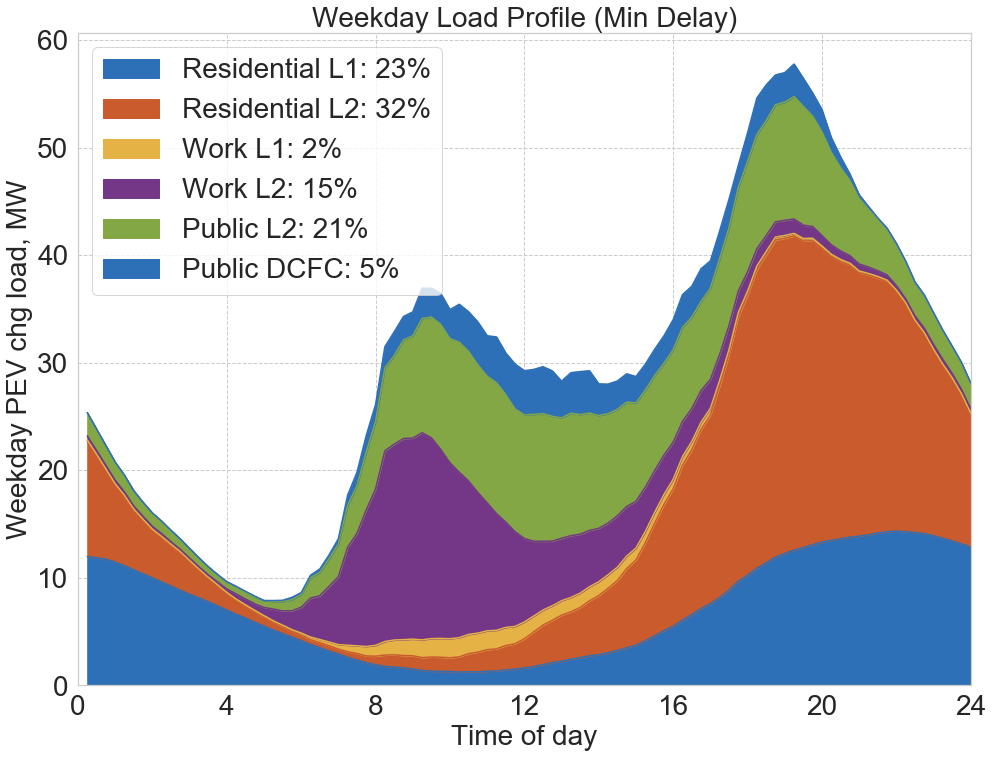

In [171]:
plot_df[cols].plot.area(figsize=(16, 12), color=colors)
ratios = plot_df[cols].sum(axis=0)/plot_df.sum().sum()
labels = [
    'Residential L1',
    'Residential L2',
    'Work L1',
    'Work L2',
    'Public L2',
    'Public DCFC',
]
L = plt.legend(title=None)
for i, l in enumerate(L.get_texts()):
    percent = int(ratios.values[i] * 100) 
    l.set_text(f"{labels[i]}: {percent}%")
    
plt.grid(linestyle='dashed')
plt.title(f"Weekday Load Profile (Min Delay)")
plt.xlabel("Time of day")
plt.xlim(0,24)
plt.xticks(np.arange(0,25,4))
plt.ylabel("Weekday PEV chg load, MW")

In [173]:
api_string = ("https://evi-pro-vue.afdc-stage.nrel.gov/evi-pro-lite/api/v1/"
              f"daily-load-profile?temp_c={temp_c}&fleet_size={fleet_size}&"
              f"mean_dvmt={mean_dvmt}&pev_dist={pev_dist}&pref_dist={pref_dist}&"
              f"home_access_dist={home_access_dist}&home_power_dist={home_power_dist}&"
              f"work_power_dist={work_power_dist}&class_dist={class_dist}")

In [174]:
api_string

'https://evi-pro-vue.afdc-stage.nrel.gov/evi-pro-lite/api/v1/daily-load-profile?temp_c=10&fleet_size=30000&mean_dvmt=35&pev_dist=BEV&pref_dist=Home100&home_access_dist=HA75&home_power_dist=Equal&work_power_dist=MostL2&class_dist=Equal'

In [175]:
result = requests.get(api_string).json()

In [194]:
out_df = pd.DataFrame(result['results']['weekend_load_profile'])

In [195]:
out_df.index = (out_df.index + 1) * 15 / 60

In [196]:
out_df.head()

,home_l1,home_l2,work_l1,work_l2,public_l2,public_l3
0.25,6298.34,7501.61,40.88,145.18,2044.46,5.71
0.50,6252.76,6799.67,38.31,129.07,1902.64,0.00
0.75,6181.84,6252.58,37.80,103.87,1744.60,0.00
1.00,6060.82,5670.84,36.73,90.02,1504.81,0.00
1.25,5903.81,5238.65,32.11,67.89,1271.63,0.00


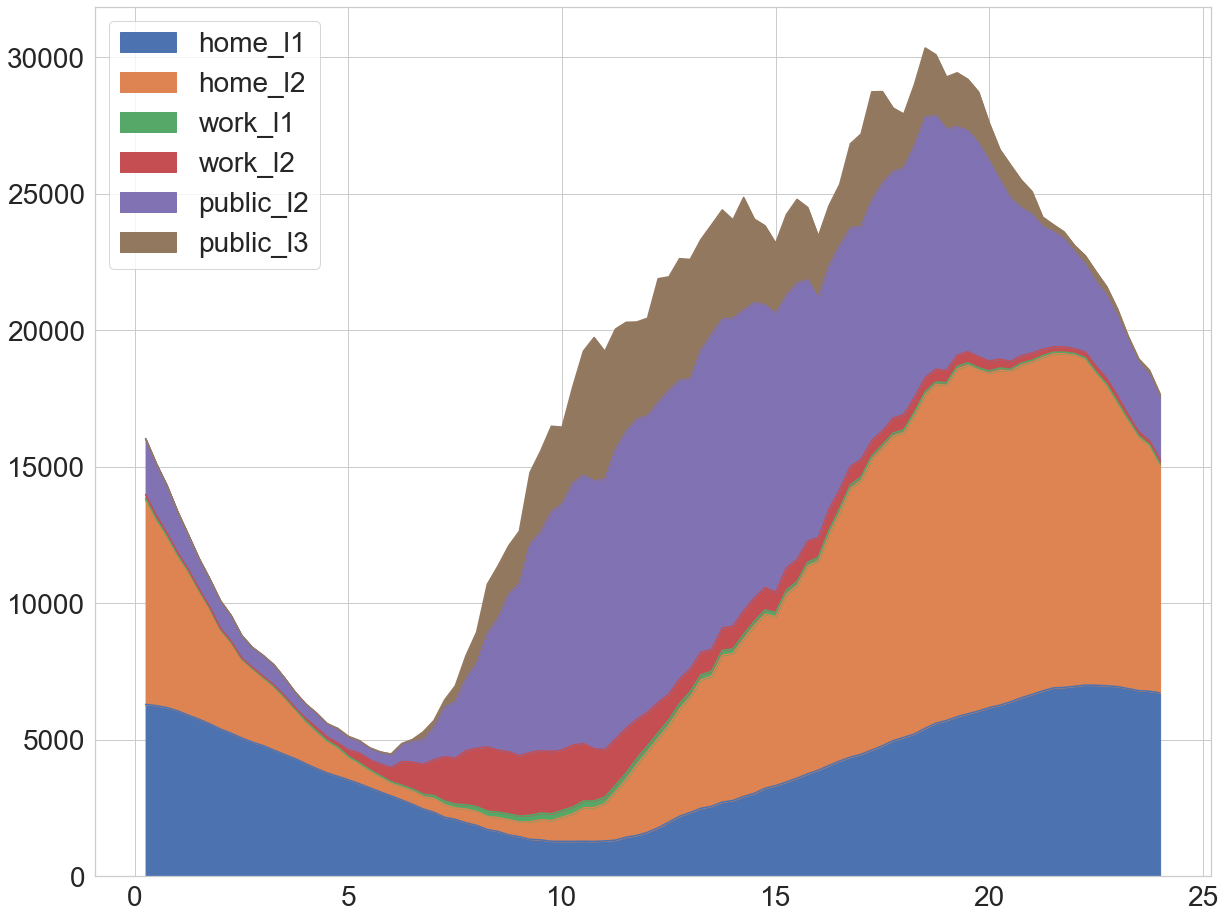

In [197]:
out_df.plot.area(figsize=(20,16))

In [198]:
out_df.to_csv('weekend_load_profile_30000_PEV.csv')